# **LSTM (Long Short Term Memory) Implementation**
We attempt to predict the closing price of NVDA from the period 2022-10-24 to 2022-11-04 using LSTM model

LSTMs are a type of Recurrent Neural Network which are neural networks with some form of "memory" as information from prior inputs have the ability to influence the current input and output.

Weights and biases are shared and thus RNNs leverage a modified backpropagation algorithm that lends itself to the exploding and vanishing gradient problems.

LSTMs are a variety of RNNs that handle the exploding and vanishing gradient problems and are a popular choice for forecasting time series with Deep Learning.

In [28]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Data
We use the `yfinance` library to download data on NVDA stock
- The data is further processed by taking only the 'Close' column which is the variable we are attempting to forecast

We also have to transform the time series into a supervised learning problem with inputs and outputs
- Here we select a time step of 5 days, that is we take the closing prices of the past 5 days as input and the close of the actual day as output which we create using the pandas `shift()` function

[*********************100%***********************]  1 of 1 completed


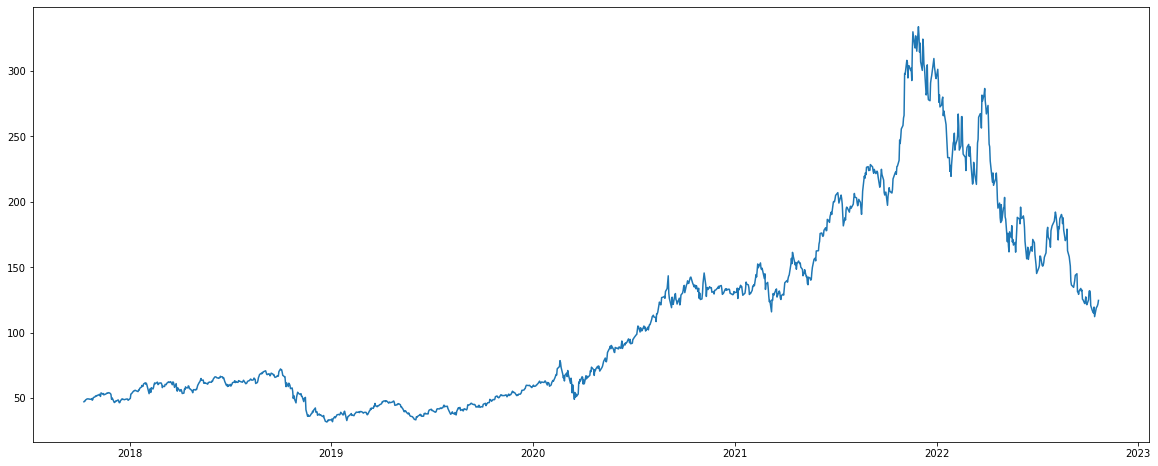

In [29]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (20,8)
nvda = yf.Ticker('NVDA')
df = yf.download('NVDA', start='2017-10-10', end='2022-10-22')
df.index = pd.to_datetime(df.index)
df = df[['Close']]
plt.plot(df)

In [30]:
import numpy as np
time_step = 3 
def parse_to_window(start_date_str, end_date_str, n=3):
  new_df = df.copy()
  while (n != 0):
    new_df[f'Target-{n}'] = new_df.shift(n)['Close']
    n = n - 1
  new_df = new_df.loc[start_date_str:end_date_str]
  cols = new_df.columns.tolist()
  new_df = new_df[cols[1:]+cols[0:1]]
  return new_df.reset_index()
new_df = parse_to_window('2020-10-05', '2022-10-22', time_step)
new_df

,Date,Target-3,Target-2,Target-1,Close
0,2020-10-05,135.304993,136.145004,130.622498,136.425003
1,2020-10-06,136.145004,130.622498,136.425003,137.365005
2,2020-10-07,130.622498,136.425003,137.365005,139.639999
3,2020-10-08,136.425003,137.365005,139.639999,138.387497
4,2020-10-09,137.365005,139.639999,138.387497,137.627502
...,...,...,...,...,...
512,2022-10-17,115.000000,119.599998,112.269997,118.879997
513,2022-10-18,119.599998,112.269997,118.879997,119.669998
514,2022-10-19,112.269997,118.879997,119.669998,120.510002
515,2022-10-20,118.879997,119.669998,120.510002,121.940002


In [31]:
def windowed_df_to_date_X_y(windowed_dataframe):
  windowed_df_as_np = windowed_dataframe.to_numpy()
  dates = windowed_df_as_np[:, 0]
  target_and_n_prev = windowed_df_as_np[:, 1:-1]
  X = target_and_n_prev.reshape((len(dates), target_and_n_prev.shape[1], 1))
  Y = windowed_df_as_np[:, -1]
  return dates, X.astype(np.float32), Y.astype(np.float32)
dates, X, y = windowed_df_to_date_X_y(new_df)
dates.shape, X.shape, y.shape

((517,), (517, 3, 1), (517,))

## Train-Val-Test Split
We split our data into training, validation and test sets using a 60-20-20 split

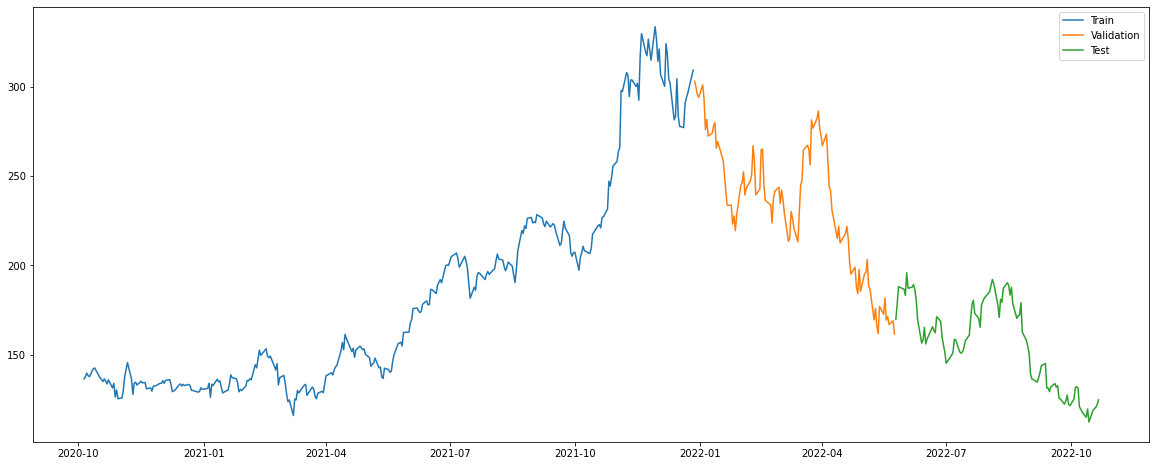

In [32]:
# train-val-test split
first_60 = int(len(dates) * .6)
first_80 = int(len(dates) * .8) 
dates_train, X_train, y_train = dates[:first_60], X[:first_60], y[:first_60]
dates_val, X_val, y_val = dates[first_60:first_80], X[first_60:first_80], y[first_60:first_80]
dates_test, X_test, y_test = dates[first_80:], X[first_80:], y[first_80:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])


## Training the Model
Keras provides methods for creating and training a LSTM model
- ReLU is chosen as the activation function and the input sequence is specified to allow the LSTM layer to accept the specified input sequence shape
- ADAM optimizer is used to adaptively adjust the learning rate and an early stopping callback is set in place to stop training the model if the epochs yield negligible change to the loss function

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(1221)
model = Sequential()
model.add(LSTM(28 , activation='relu', input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True) 
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=80, callbacks=[monitor])

Epoch 1/80
10/10 [==============================] - 1s 36ms/step - loss: 30136.5645 - mean_absolute_error: 165.6855 - val_loss: 45314.1992 - val_mean_absolute_error: 210.3002
Epoch 2/80
10/10 [==============================] - 0s 11ms/step - loss: 28537.0000 - mean_absolute_error: 161.1936 - val_loss: 42802.2188 - val_mean_absolute_error: 204.3712
Epoch 3/80
10/10 [==============================] - 0s 32ms/step - loss: 26875.4395 - mean_absolute_error: 156.4194 - val_loss: 40098.6328 - val_mean_absolute_error: 197.7997
Epoch 4/80
10/10 [==============================] - 0s 12ms/step - loss: 25148.3809 - mean_absolute_error: 151.2155 - val_loss: 37343.9180 - val_mean_absolute_error: 190.8301
Epoch 5/80
10/10 [==============================] - 0s 12ms/step - loss: 22413.0605 - mean_absolute_error: 142.3701 - val_loss: 28601.6699 - val_mean_absolute_error: 166.9061
Epoch 6/80
10/10 [==============================] - 0s 11ms/step - loss: 14351.3916 - mean_absolute_error: 113.3283 - val_los

## Plots of Actual vs Predicted Forecasts for Train, Val and Test

10/10 [==============================] - 0s 3ms/step


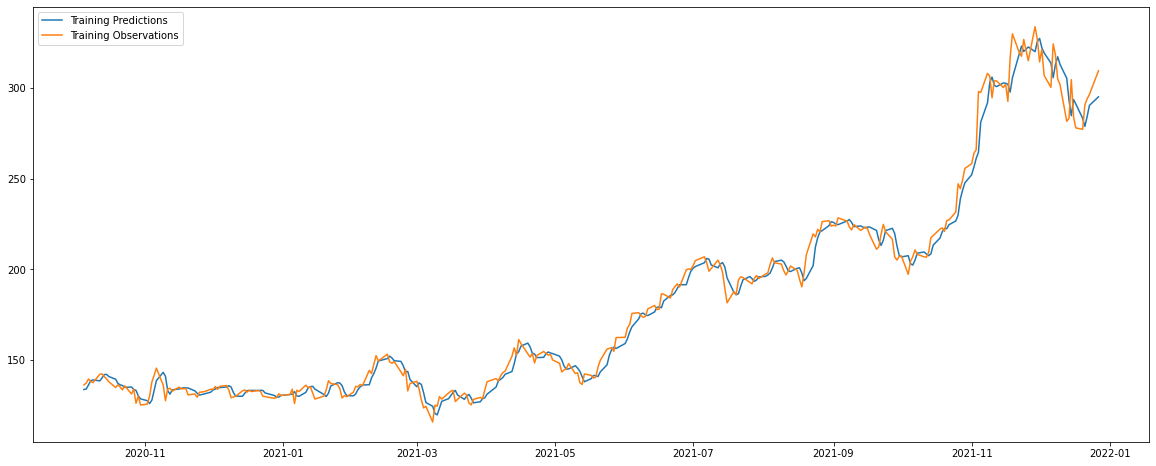

In [34]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 5ms/step


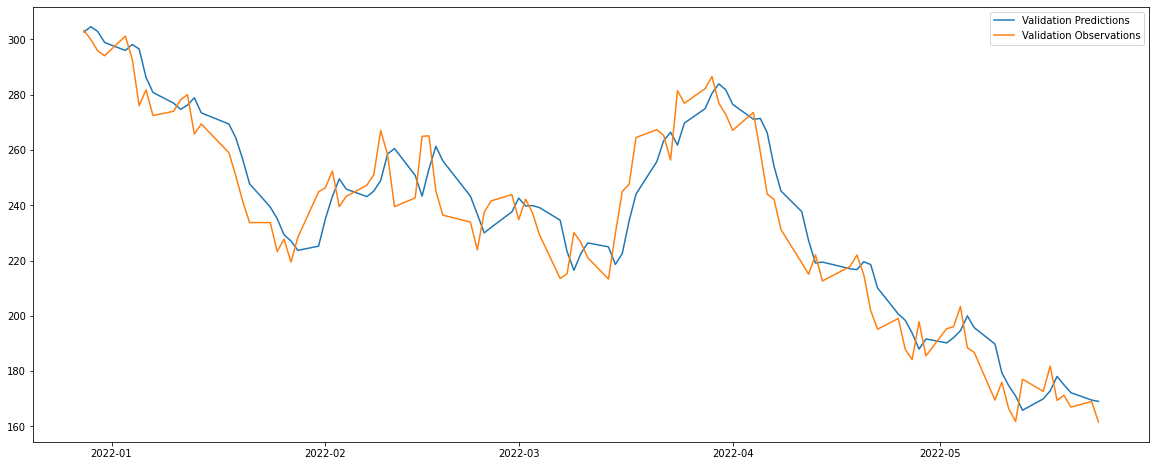

In [35]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 7ms/step


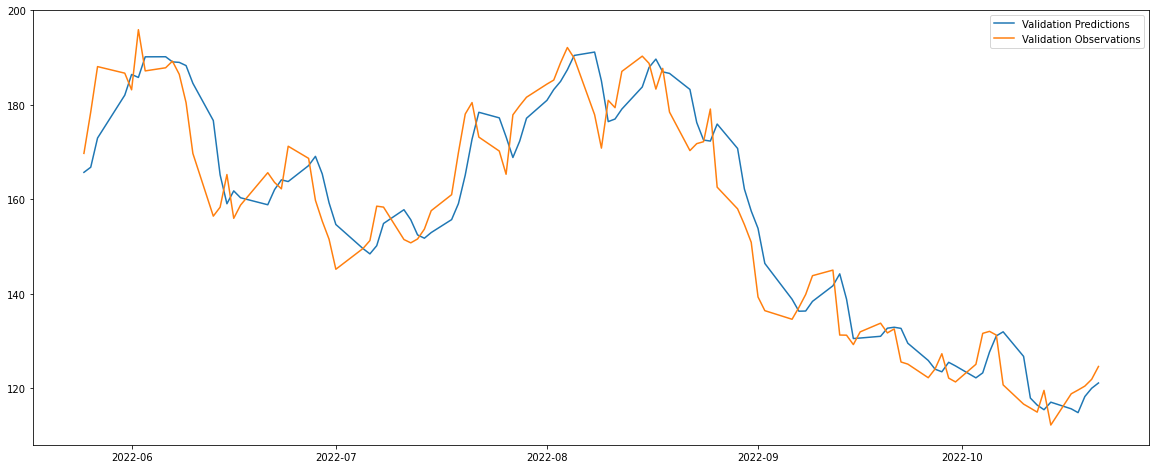

In [36]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Validation Predictions', 'Validation Observations'])

## Recursive Predictions for Test Set
We attempt to recursively forecast the values of the test set and compare them against the actual observations.
- This will also be the algorithm that we will use to create our forecasts for the dates '2022-10-24' to '2022-11-04'

In [37]:
recursive_predictions = []
recursive_dates = dates_test[-14:]
last_window = X_test[-14]

for target_date in recursive_dates: 
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  new_window = list(last_window[1:])
  new_window.append(next_prediction)
  new_window = np.array(new_window)
  last_window = new_window

1/1 [==============================] - 0s 14ms/step


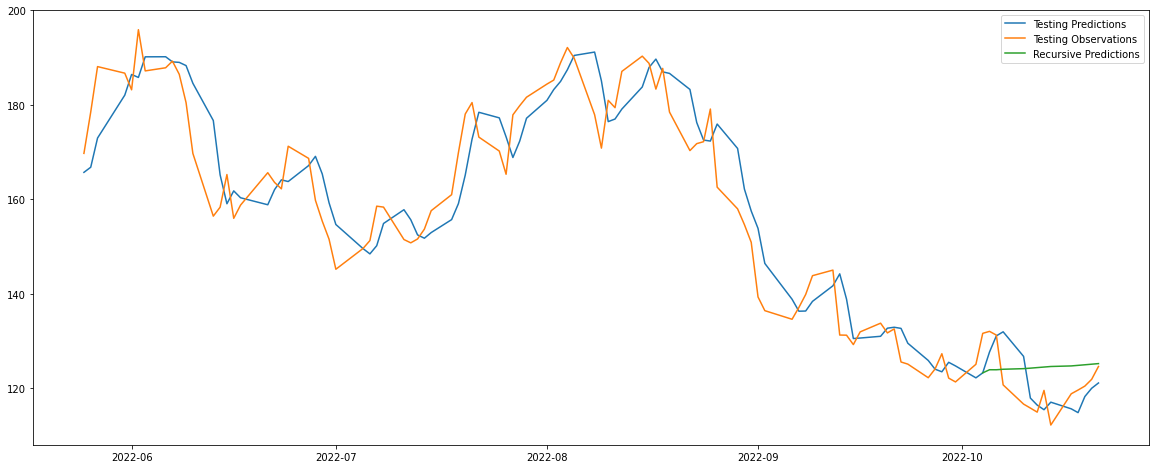

In [38]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

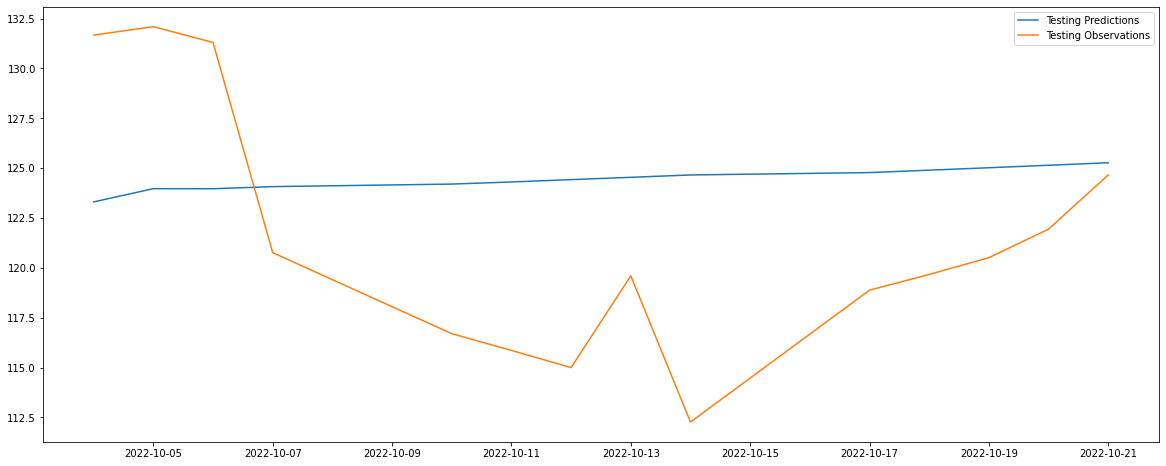

In [39]:
plt.plot(recursive_dates, recursive_predictions)
plt.plot(recursive_dates, y_test[-14:])
plt.legend(['Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [40]:
next_ten_closes = []
next_ten_dates = ['2022-10-24','2022-10-25','2022-10-26','2022-10-27','2022-10-28','2022-10-31','2022-11-01','2022-11-02','2022-11-03','2022-11-04']
lst = list(X_test[-1][1:]) 
lst.append(y_test[-1:])
latest_window = np.array(lst)
print(latest_window)
for target_date in next_ten_dates: 
  next_prediction = model.predict(np.array([latest_window])).flatten()
  print(next_prediction)
  next_ten_closes.append(next_prediction)
  new_window = list(latest_window[1:])
  new_window.append(next_prediction)
  new_window = np.array(new_window)
  latest_window = new_window
next_ten_forecasts = pd.DataFrame(next_ten_closes, columns=['Close'])
next_ten_forecasts.index.name = 'Index'
next_ten_forecasts.to_csv('Gavin_Goh_Jun_Chong_Impl_1.csv')

[[120.51]
 [121.94]
 [124.66]]
1/1 [==============================] - 0s 16ms/step
[123.138466]
1/1 [==============================] - 0s 16ms/step
[123.793175]
1/1 [==============================] - 0s 25ms/step
[123.76382]
1/1 [==============================] - 0s 18ms/step
[123.881195]
1/1 [==============================] - 0s 15ms/step
[124.00163]
1/1 [==============================] - 0s 15ms/step
[124.105675]
1/1 [==============================] - 0s 17ms/step
[124.22076]
1/1 [==============================] - 0s 16ms/step
[124.33403]
1/1 [==============================] - 0s 21ms/step
[124.44938]
1/1 [==============================] - 0s 18ms/step
[124.566185]


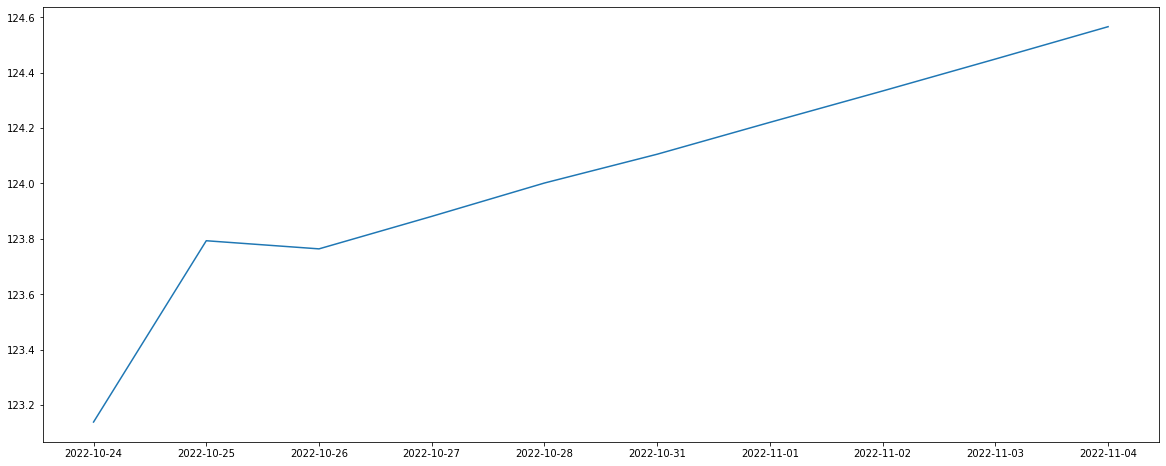

In [41]:
plt.plot(next_ten_dates, next_ten_forecasts)